# Starbucks Capstone Purchasing Decision Analyzer

# Business Understanding

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


In [142]:
# import libraries 
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy import stats

# import libraries for modelling
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix

#from statsmodels.stats.weightstats import DescrStatsW
#from sklearn.preprocessing import StandardScaler
#import tensorflow as tf
#import keras

%matplotlib inline

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript_all.json', orient='records', lines=True)

# Data Understanding



In [3]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [4]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [5]:
portfolio.describe()

,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


In [6]:
#how many different types of offers are available?  
portfolio.id.nunique()

10

In [7]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [8]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [9]:
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [10]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [11]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


# Part 1 - Data Preparation and Cleaning

## Data Cleaning "Portfolio" Data

- create a copy of the dataframe (portfolio --> portfolio01)
- convert the column 'channels' into four separate columns regarding the different types
- rename the column'id' to 'offer_id'

In [12]:
portfolio01 = portfolio.copy()

In [13]:
portfolio01['channels']

0         [email, mobile, social]
1    [web, email, mobile, social]
2            [web, email, mobile]
3            [web, email, mobile]
4                    [web, email]
5    [web, email, mobile, social]
6    [web, email, mobile, social]
7         [email, mobile, social]
8    [web, email, mobile, social]
9            [web, email, mobile]
Name: channels, dtype: object

In [14]:
#Add dummy variable for channels
dummy_var = pd.get_dummies(portfolio01.channels.apply(pd.Series).stack()).sum(level=0)
portfolio01 = pd.concat([portfolio01, dummy_var], axis=1)

In [15]:
#Check
portfolio01.head()

,channels,difficulty,duration,id,offer_type,reward,email,mobile,social,web
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1


In [16]:
#Drop old channel column
portfolio01 = portfolio01.drop(columns='channels')

In [17]:
#Check
portfolio01.head()

,difficulty,duration,id,offer_type,reward,email,mobile,social,web
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1


In [18]:
portfolio01 = portfolio01.rename(columns={'id':'offer_id'})

In [19]:
#Check
portfolio01.head()

,difficulty,duration,offer_id,offer_type,reward,email,mobile,social,web
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1


In [20]:
portfolio01.duplicated().sum()

0

## Data Cleaning "Profile" Data

- create a copy of the dataframe (profile --> profile01)
- convert the datatype of 'became_member_on' column
- convert the date into good format
- rename the column'id' to 'customer_id'

In [21]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [22]:
profile01 = profile.copy()

In [23]:
profile01['became_member_on'] = pd.to_datetime(profile01['became_member_on'], format='%Y%m%d')

In [24]:
#Check
profile01.head()

,age,became_member_on,gender,id,income
0,118,2017-02-12,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,2018-07-12,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,2017-08-04,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [25]:
profile01 = profile01.rename(columns={'id':'customer_id'})

In [26]:
#Check
profile01.head()

,age,became_member_on,gender,customer_id,income
0,118,2017-02-12,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,2018-07-12,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,2017-08-04,None,a03223e636434f42ac4c3df47e8bac43,NaN


## Data Cleaning "Transcript" Data

- create a copy of the dataframe (transcript --> transcript01)
- change column name from 'person' to 'customer_id'
- convert the column 'event' into four columns based on different types of event
- convert the column 'values' into two columns

In [27]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [28]:
transcript01 = transcript.copy()

In [29]:
transcript01 = transcript01.rename(columns={'person':'customer_id'})

In [30]:
#rename events
transcript01['event'] = transcript01['event'].str.replace(' ', '_')

In [31]:
#Check
transcript01['event'].value_counts()

transaction        138953
offer_received      76277
offer_viewed        57725
offer_completed     33579
Name: event, dtype: int64

In [32]:
dummy_var02 = pd.get_dummies(transcript01['event'])
transcript01 = pd.concat([transcript01, dummy_var02], axis=1)

In [33]:
#Check
transcript01.head(400)

,event,customer_id,time,value,offer_completed,offer_received,offer_viewed,transaction
0,offer_received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,1,0,0
1,offer_received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,1,0,0
2,offer_received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,1,0,0
3,offer_received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,1,0,0
4,offer_received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,1,0,0
5,offer_received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0,1,0,0
6,offer_received,c4863c7985cf408faee930f111475da3,0,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},0,1,0,0
7,offer_received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0,1,0,0
8,offer_received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,1,0,0
9,offer_received,31dda685af34476cad5bc968bdb01c53,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,1,0,0


In [34]:
#Check
print(transcript01['offer_completed'].value_counts())
print(transcript01['offer_received'].value_counts())
print(transcript01['offer_viewed'].value_counts())
print(transcript01['transaction'].value_counts())

0    272955
1     33579
Name: offer_completed, dtype: int64
0    230257
1     76277
Name: offer_received, dtype: int64
0    248809
1     57725
Name: offer_viewed, dtype: int64
0    167581
1    138953
Name: transaction, dtype: int64


Problem: value - (dict of strings) - either an offer id or transaction amount depending on the record

In [35]:
transcript01['offer_id'] = [[*i.values()][0]if [*i.keys()][0] in ['offer id','offer_id'] else None for i in transcript01.value]
transcript01['transaction_amount'] = [np.round([*i.values()][0], decimals=2)if [*i.keys()][0] == 'amount' else None for i in transcript01.value]

In [36]:
#Check
transcript01.head()

,event,customer_id,time,value,offer_completed,offer_received,offer_viewed,transaction,offer_id,transaction_amount
0,offer_received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,offer_received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,offer_received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,1,0,0,2906b810c7d4411798c6938adc9daaa5,NaN
3,offer_received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,1,0,0,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,offer_received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


In [37]:
#Drop not needed columns
transcript01 = transcript01.drop(columns='value')
transcript01 = transcript01.drop(columns='event')

In [38]:
#Check
transcript01.head()

,customer_id,time,offer_completed,offer_received,offer_viewed,transaction,offer_id,transaction_amount
0,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,0,0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,0,0,1,0,0,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,0,1,0,0,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,0,0,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


# EDA Part 1 - Exploratory Data Analysis (EDA) and Data Visualiszation

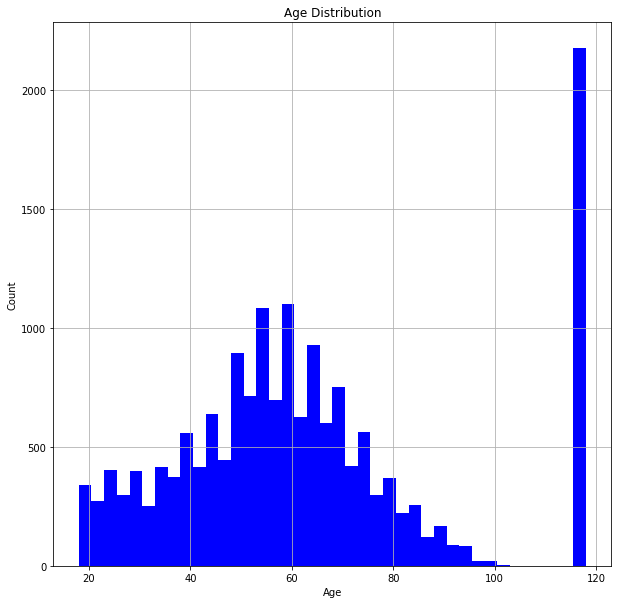

In [39]:
#first draft of age shows >2000 count of people with age 118 --> data cleaning needed
profile01.age.hist(bins = 40, facecolor='b', figsize=(10,10))
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age Distribution');

In [40]:
#check age column because of people that are 118 years old 
profile01[profile01.age == 118][['gender','age','income','became_member_on']]

,gender,age,income,became_member_on
0,None,118,NaN,2017-02-12
2,None,118,NaN,2018-07-12
4,None,118,NaN,2017-08-04
6,None,118,NaN,2017-09-25
7,None,118,NaN,2017-10-02
9,None,118,NaN,2016-11-22
10,None,118,NaN,2017-08-24
11,None,118,NaN,2015-09-19
17,None,118,NaN,2017-08-01
23,None,118,NaN,2017-09-07


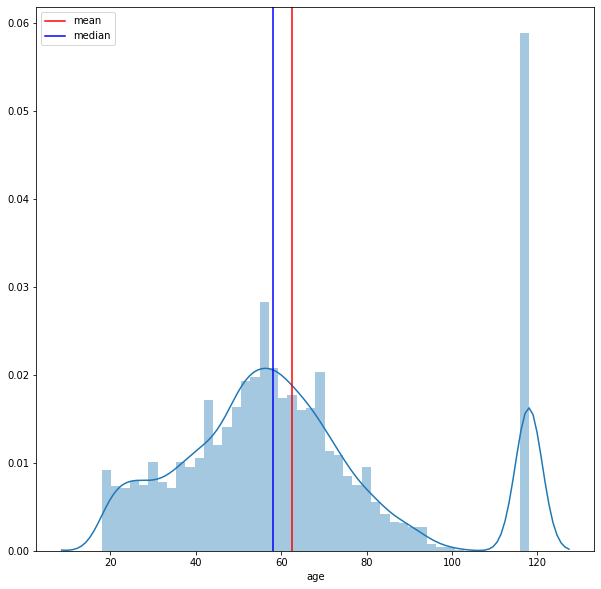

In [41]:
#define mean and median
mean = scipy.mean(profile01['age'])
median = scipy.median(profile01['age'])

#plot graph
plt.figure(figsize=(10,10))
sns.distplot(profile01['age'])
plt.axvline(mean, color='r',label='mean')
plt.axvline(median, color='b',label='median')
plt.legend()

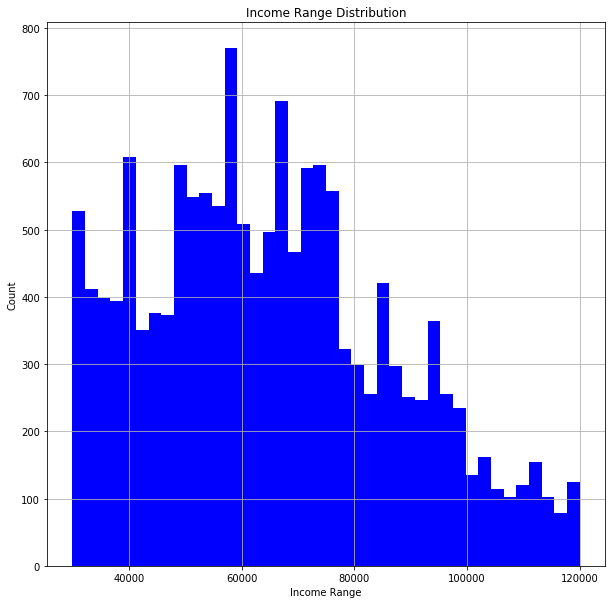

In [42]:
profile01.income.hist(bins = 40, facecolor='b', figsize=(10,10));
plt.xlabel('Income Range')
plt.ylabel('Count')
plt.title('Income Range Distribution');

In [43]:
profile01['income'].describe().astype(int)

count     14825
mean      65404
std       21598
min       30000
25%       49000
50%       64000
75%       80000
max      120000
Name: income, dtype: int64

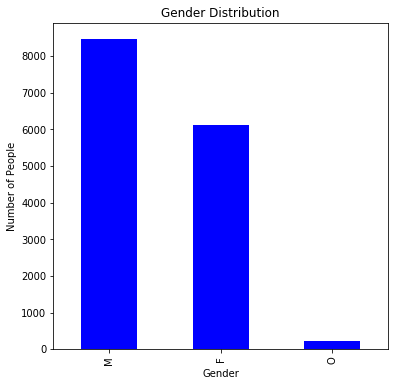

In [44]:
graph1 = profile01.gender.value_counts()
graph1.plot(kind='bar', facecolor='b', figsize=(6,6))
plt.ylabel('Number of People')
plt.xlabel('Gender')
plt.title('Gender Distribution');

# Part 2 - Data Preparation and Cleaning

In [45]:
#check and clean age column

#profile01[profile01.age == 118][['gender','age','income']]
profile01.describe()

,age,income
count,17000.000000,14825.000000
mean,62.531412,65404.991568
std,26.738580,21598.299410
min,18.000000,30000.000000
25%,45.000000,49000.000000
50%,58.000000,64000.000000
75%,73.000000,80000.000000
max,118.000000,120000.000000


In [46]:
index_del = profile01[profile01["age"] == 118].index
profile01.drop(index_del, inplace=True)

In [47]:
profile01.describe()

,age,income
count,14825.000000,14825.000000
mean,54.393524,65404.991568
std,17.383705,21598.299410
min,18.000000,30000.000000
25%,42.000000,49000.000000
50%,55.000000,64000.000000
75%,66.000000,80000.000000
max,101.000000,120000.000000


# EDA Part 2 - Exploratory Data Analysis (EDA) and Data Visualiszation

## Age 

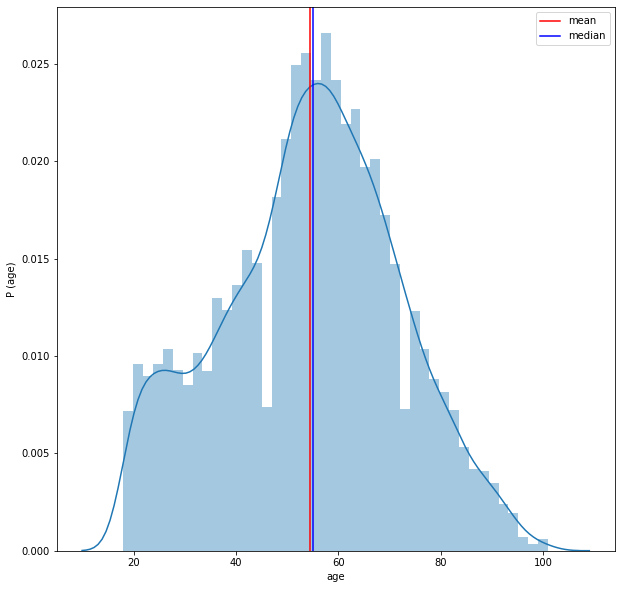

In [48]:
#define mean and median for age
mean = scipy.mean(profile01['age'])
median = scipy.median(profile01['age'])

#plot graph
plt.figure(figsize=(10,10))
sns.distplot(profile01['age'])
plt.axvline(mean, color='r',label='mean')
plt.axvline(median, color='b',label='median')
plt.ylabel('P (age)')
plt.legend()

In [49]:
print('Mean age = ', mean)
print('Median age = ', median)

Mean age =  54.39352445193929
Median age =  55.0


In [50]:
#Check
#check age column because of people that are 118 years old 
profile01[profile01.age == 118][['gender','age','income','became_member_on']]

,gender,age,income,became_member_on


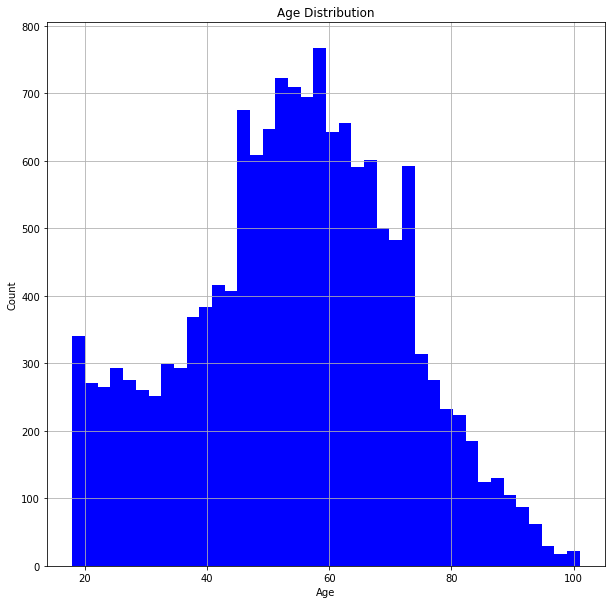

In [51]:
profile01.age.hist(bins = 40, facecolor='b', figsize=(10,10))
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age Distribution');

## Income

In [52]:
#define mean and median for income
mean = scipy.mean(profile01['income'])
median = scipy.median(profile01['income'])

print('Mean income = ', mean)
print('Median income = ', median)

Mean income =  65404.9915682968
Median income =  64000.0


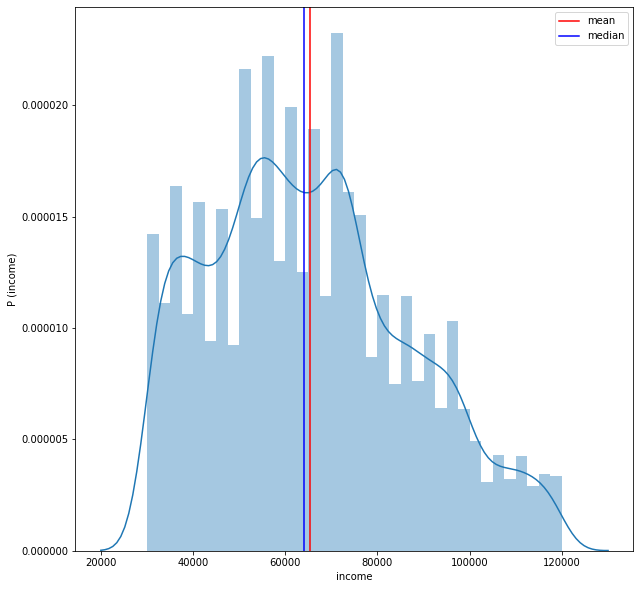

In [53]:
#plot graph
plt.figure(figsize=(10,10))
sns.distplot(profile01['income'])
plt.axvline(mean, color='r',label='mean')
plt.axvline(median, color='b',label='median')
plt.ylabel('P (income)')
plt.legend()

## Gender

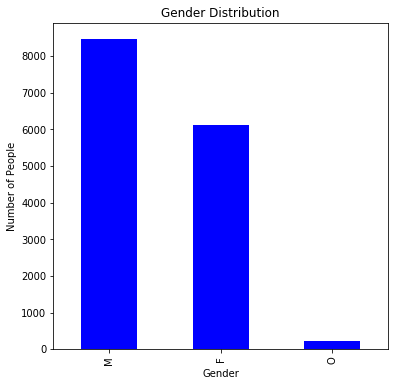

In [54]:
graph1 = profile01.gender.value_counts()
graph1.plot(kind='bar', facecolor='b', figsize=(6,6))
plt.ylabel('Number of People')
plt.xlabel('Gender')
plt.title('Gender Distribution');

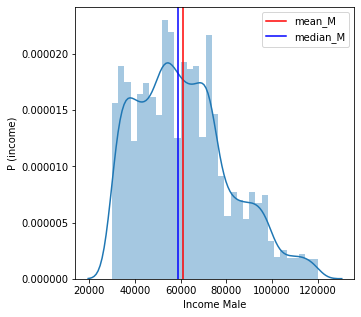

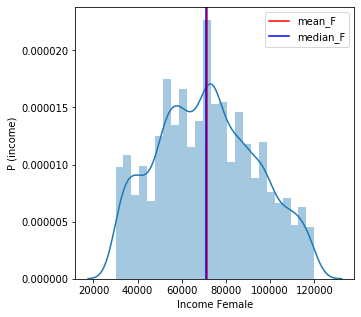

In [55]:
male_cust = profile01[profile01['gender'] == 'M']
female_cust = profile01[profile01['gender'] == 'F']

mean_male = scipy.mean(male_cust['income'])
median_male = scipy.median(male_cust['income'])

mean_female = scipy.mean(female_cust['income'])
median_female = scipy.median(female_cust['income'])

#organize subplots
#fig, ax = plt.subplots(figsize=(10, 4),nrows=1,ncols=2,sharex=True,sharey=True)

#plot graph
#plt.sca(ax[0])
plt.figure(figsize=(5,5))
sns.distplot(male_cust['income'])
plt.axvline(mean_male, color='r',label='mean_M')
plt.axvline(median_male, color='b',label='median_M')
plt.ylabel('P (income)')
plt.xlabel('Income Male')
plt.legend()

#plt.sca(ax[1])
plt.figure(figsize=(5,5))
sns.distplot(female_cust['income'])
plt.axvline(mean_female, color='r',label='mean_F')
plt.axvline(median_female, color='b',label='median_F')
plt.ylabel('P (income)')
plt.xlabel('Income Female')
plt.legend()

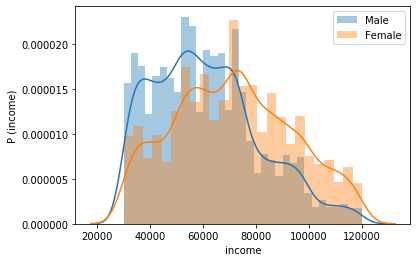

In [56]:
#gender income distribution in one graph
sns.distplot(profile01[profile01.gender=='M'].income,label='Male')
sns.distplot(profile01[profile01.gender=='F'].income,label='Female')
plt.ylabel('P (income)')
plt.legend()
plt.show()

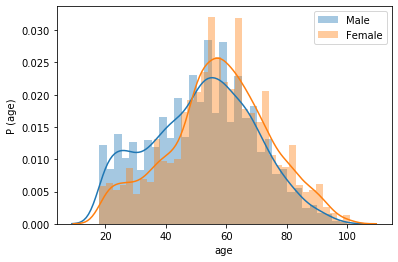

In [57]:
#gender age distribution in one graph
sns.distplot(profile01[profile01.gender=='M'].age,label='Male')
sns.distplot(profile01[profile01.gender=='F'].age,label='Female')
plt.ylabel('P (age)')
plt.legend()
plt.show()

## Member Status 

In [58]:
#what year a customer became a rewards member
became_member_on = profile01['became_member_on']

start_year = became_member_on.apply(lambda elem: elem.year).value_counts()
start_year *= 100 / start_year.sum()
start_year

2017    37.767285
2018    24.748735
2016    20.397976
2015    10.772344
2014     4.465430
2013     1.848229
Name: became_member_on, dtype: float64

# Merge the datasets

In [59]:
profile01.head(2)

,age,became_member_on,gender,customer_id,income
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0


In [60]:
transcript01.head(2)

,customer_id,time,offer_completed,offer_received,offer_viewed,transaction,offer_id,transaction_amount
0,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,0,0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN


In [61]:
portfolio01.head(2)

,difficulty,duration,offer_id,offer_type,reward,email,mobile,social,web
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1


In [62]:
#merge profile01 and transcript01 on customer_id
df_profile01_transcript01 = pd.merge(profile01, transcript01, on='customer_id')

In [63]:
#merge df_profile01_transcript01 and portfolio01 on offer_id
df = pd.merge(df_profile01_transcript01, portfolio01, on='offer_id', how='left')

In [64]:
df.head(10)

,age,became_member_on,gender,customer_id,income,time,offer_completed,offer_received,offer_viewed,transaction,offer_id,transaction_amount,difficulty,duration,offer_type,reward,email,mobile,social,web
0,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,18,0,0,0,1,None,21.51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,144,0,0,0,1,None,32.28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,408,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5.0,7.0,bogo,5.0,1.0,1.0,0.0,1.0
3,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,504,0,1,0,0,3f207df678b143eea3cee63160fa8bed,NaN,0.0,4.0,informational,0.0,1.0,1.0,0.0,1.0
4,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,528,0,0,0,1,None,23.22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,528,1,0,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5.0,7.0,bogo,5.0,1.0,1.0,0.0,1.0
6,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5.0,7.0,bogo,5.0,1.0,1.0,0.0,1.0
7,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,6,0,0,1,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5.0,7.0,bogo,5.0,1.0,1.0,0.0,1.0
8,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,132,0,0,0,1,None,19.89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,132,1,0,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5.0,7.0,bogo,5.0,1.0,1.0,0.0,1.0


In [65]:
###fix problems in the df

In [66]:
offer_id = df['offer_id'].unique()
offer_id

array([None, '9b98b8c7a33c4b65b9aebfe6a799e6d9',
       '3f207df678b143eea3cee63160fa8bed',
       '5a8bc65990b245e5a138643cd4eb9837',
       'ae264e3637204a6fb9bb56bc8210ddfd',
       'f19421c1d4aa40978ebb69ca19b0e20d',
       '2906b810c7d4411798c6938adc9daaa5',
       'fafdcd668e3743c1bb461111dcafc2a4',
       '2298d6c36e964ae4a3e7e9706d1fb8c2',
       '0b1e1539f2cc45b7b9fa7c272da2e1d7',
       '4d5c57ea9a6940dd891ad53e9dbe8da0'], dtype=object)

In [67]:
offer_set = pd.Series(offer_id).to_dict()
offer_set

{0: None,
 1: '9b98b8c7a33c4b65b9aebfe6a799e6d9',
 2: '3f207df678b143eea3cee63160fa8bed',
 3: '5a8bc65990b245e5a138643cd4eb9837',
 4: 'ae264e3637204a6fb9bb56bc8210ddfd',
 5: 'f19421c1d4aa40978ebb69ca19b0e20d',
 6: '2906b810c7d4411798c6938adc9daaa5',
 7: 'fafdcd668e3743c1bb461111dcafc2a4',
 8: '2298d6c36e964ae4a3e7e9706d1fb8c2',
 9: '0b1e1539f2cc45b7b9fa7c272da2e1d7',
 10: '4d5c57ea9a6940dd891ad53e9dbe8da0'}

In [68]:
#create offer set
offer_set = dict([(value, key) for key, value in offer_set.items()]) 
offer_set

{None: 0,
 '9b98b8c7a33c4b65b9aebfe6a799e6d9': 1,
 '3f207df678b143eea3cee63160fa8bed': 2,
 '5a8bc65990b245e5a138643cd4eb9837': 3,
 'ae264e3637204a6fb9bb56bc8210ddfd': 4,
 'f19421c1d4aa40978ebb69ca19b0e20d': 5,
 '2906b810c7d4411798c6938adc9daaa5': 6,
 'fafdcd668e3743c1bb461111dcafc2a4': 7,
 '2298d6c36e964ae4a3e7e9706d1fb8c2': 8,
 '0b1e1539f2cc45b7b9fa7c272da2e1d7': 9,
 '4d5c57ea9a6940dd891ad53e9dbe8da0': 10}

In [69]:
#map offer_id and offer_set
df['offer_id'] = df['offer_id'].map(offer_set)
df.head(10)


,age,became_member_on,gender,customer_id,income,time,offer_completed,offer_received,offer_viewed,transaction,offer_id,transaction_amount,difficulty,duration,offer_type,reward,email,mobile,social,web
0,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,18,0,0,0,1,0,21.51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,144,0,0,0,1,0,32.28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,408,0,1,0,0,1,NaN,5.0,7.0,bogo,5.0,1.0,1.0,0.0,1.0
3,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,504,0,1,0,0,2,NaN,0.0,4.0,informational,0.0,1.0,1.0,0.0,1.0
4,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,528,0,0,0,1,0,23.22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,528,1,0,0,0,1,NaN,5.0,7.0,bogo,5.0,1.0,1.0,0.0,1.0
6,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,0,0,1,0,0,1,NaN,5.0,7.0,bogo,5.0,1.0,1.0,0.0,1.0
7,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,6,0,0,1,0,1,NaN,5.0,7.0,bogo,5.0,1.0,1.0,0.0,1.0
8,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,132,0,0,0,1,0,19.89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,132,1,0,0,0,1,NaN,5.0,7.0,bogo,5.0,1.0,1.0,0.0,1.0


In [70]:
#replace None with nan
df['offer_id'] = df['offer_id'].replace(0, np.nan)
df.head(10)

,age,became_member_on,gender,customer_id,income,time,offer_completed,offer_received,offer_viewed,transaction,offer_id,transaction_amount,difficulty,duration,offer_type,reward,email,mobile,social,web
0,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,18,0,0,0,1,NaN,21.51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,144,0,0,0,1,NaN,32.28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,408,0,1,0,0,1.0,NaN,5.0,7.0,bogo,5.0,1.0,1.0,0.0,1.0
3,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,504,0,1,0,0,2.0,NaN,0.0,4.0,informational,0.0,1.0,1.0,0.0,1.0
4,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,528,0,0,0,1,NaN,23.22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,528,1,0,0,0,1.0,NaN,5.0,7.0,bogo,5.0,1.0,1.0,0.0,1.0
6,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,0,0,1,0,0,1.0,NaN,5.0,7.0,bogo,5.0,1.0,1.0,0.0,1.0
7,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,6,0,0,1,0,1.0,NaN,5.0,7.0,bogo,5.0,1.0,1.0,0.0,1.0
8,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,132,0,0,0,1,NaN,19.89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,132,1,0,0,0,1.0,NaN,5.0,7.0,bogo,5.0,1.0,1.0,0.0,1.0


In [71]:
df['offer_id'].unique()

array([nan,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

In [72]:
df.shape

(272762, 20)

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 272762 entries, 0 to 272761
Data columns (total 20 columns):
age                   272762 non-null int64
became_member_on      272762 non-null datetime64[ns]
gender                272762 non-null object
customer_id           272762 non-null object
income                272762 non-null float64
time                  272762 non-null int64
offer_completed       272762 non-null uint8
offer_received        272762 non-null uint8
offer_viewed          272762 non-null uint8
transaction           272762 non-null uint8
offer_id              148805 non-null float64
transaction_amount    123957 non-null float64
difficulty            148805 non-null float64
duration              148805 non-null float64
offer_type            148805 non-null object
reward                148805 non-null float64
email                 148805 non-null float64
mobile                148805 non-null float64
social                148805 non-null float64
web                   1

In [74]:
#save df to csv file
df.to_csv('data/data_all.csv', index=False)

## Open Data

In [78]:
df = pd.read_csv('data/data_all.csv')
df.head(5)

,age,became_member_on,gender,customer_id,income,time,offer_completed,offer_received,offer_viewed,transaction,offer_id,transaction_amount,difficulty,duration,offer_type,reward,email,mobile,social,web
0,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,18,0,0,0,1,NaN,21.51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,144,0,0,0,1,NaN,32.28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,408,0,1,0,0,1.0,NaN,5.0,7.0,bogo,5.0,1.0,1.0,0.0,1.0
3,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,504,0,1,0,0,2.0,NaN,0.0,4.0,informational,0.0,1.0,1.0,0.0,1.0
4,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,528,0,0,0,1,NaN,23.22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Offer Type and Offer Status

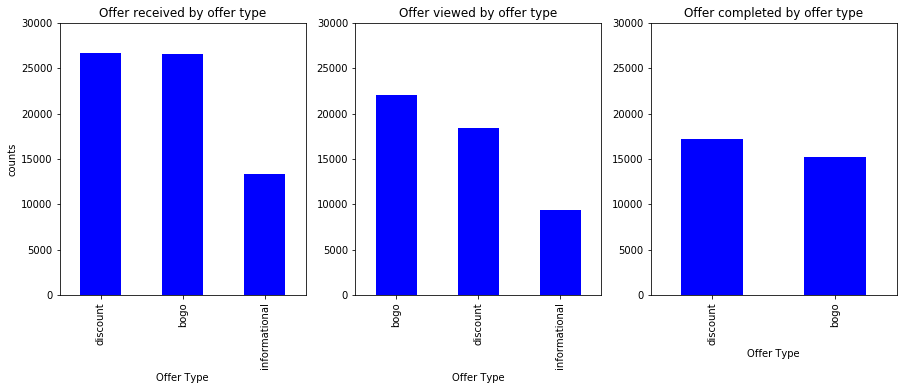

In [76]:
#graph regarding offer type and offer status from new combined df

plt.subplot(131)
offer_received = df[df['offer_received'] == 1].offer_type.value_counts()
offer_received.plot(kind='bar', facecolor='b', figsize=(15,5))
plt.yticks([0, 5000, 10000, 15000 ,20000 ,25000 , 30000])
plt.ylabel('counts')
plt.xlabel('Offer Type')
plt.title('Offer received by offer type');

plt.subplot(132)
offer_viewed = df[df['offer_viewed'] == 1].offer_type.value_counts()
offer_viewed.plot(kind='bar' , facecolor='b', figsize=(15,5))
plt.yticks([0, 5000, 10000, 15000 ,20000 ,25000 , 30000])
#plt.ylabel('counts')
plt.xlabel('Offer Type')
plt.title('Offer viewed by offer type');

plt.subplot(133)
offer_completed = df[df['offer_completed'] == 1].offer_type.value_counts()
offer_completed.plot(kind='bar' , facecolor='b', figsize=(15,5))
plt.yticks([0, 5000, 10000, 15000 ,20000 ,25000 , 30000])
#plt.ylabel('counts')
plt.xlabel('Offer Type')
plt.title('Offer completed by offer type');

## Analytics regarding different offer types

# Modelling - part 1 - Random Forest

In [109]:
df.head(5)

,age,became_member_on,gender,customer_id,income,time,offer_completed,offer_received,offer_viewed,transaction,offer_id,transaction_amount,difficulty,duration,offer_type,reward,email,mobile,social,web
0,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,18,0,0,0,1,NaN,21.51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,144,0,0,0,1,NaN,32.28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,408,0,1,0,0,1.0,NaN,5.0,7.0,bogo,5.0,1.0,1.0,0.0,1.0
3,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,504,0,1,0,0,2.0,NaN,0.0,4.0,informational,0.0,1.0,1.0,0.0,1.0
4,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,528,0,0,0,1,NaN,23.22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [111]:
#Start new df for modelling
df_mod1 = df.copy()

In [112]:
#drop customer_id and offer_id
df_mod1.drop(['customer_id', 'offer_id'], axis=1, inplace=True)

In [113]:
#remove transaction_amount
df_mod1.drop(['transaction_amount'], axis=1, inplace=True)

In [114]:
#remove became_member_on
df_mod1.drop(['became_member_on'], axis=1, inplace=True)

In [115]:
#Add dummy variable for gender
dummy_var = pd.get_dummies(df_mod1.gender.apply(pd.Series).stack()).sum(level=0)
df_mod1 = pd.concat([df_mod1, dummy_var], axis=1)
df_mod1.head(2)

,age,gender,income,time,offer_completed,offer_received,offer_viewed,transaction,difficulty,duration,offer_type,reward,email,mobile,social,web,F,M,O
0,55,F,112000.0,18,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0
1,55,F,112000.0,144,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0


In [116]:
#remove gender
df_mod1.drop(['gender'], axis=1, inplace=True)

In [122]:
#Add dummy variable for offer_type
dummy_var = pd.get_dummies(df_mod1.offer_type.apply(pd.Series).stack()).sum(level=0)
df_mod1 = pd.concat([df_mod1, dummy_var], axis=1)
df_mod1.head(2)

,age,income,time,offer_completed,offer_received,offer_viewed,transaction,difficulty,duration,offer_type,...,email,mobile,social,web,F,M,O,bogo,discount,informational
0,55,112000.0,18,0,0,0,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1,0,0,NaN,NaN,NaN
1,55,112000.0,144,0,0,0,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1,0,0,NaN,NaN,NaN


In [123]:
#remove offer_type
df_mod1.drop(['offer_type'], axis=1, inplace=True)

In [129]:
df_mod1.head(10)

,age,income,time,offer_completed,offer_received,offer_viewed,transaction,difficulty,duration,reward,email,mobile,social,web,F,M,O,bogo,discount,informational
0,55,112000.0,18,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,NaN,NaN,NaN
1,55,112000.0,144,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,NaN,NaN,NaN
2,55,112000.0,408,0,1,0,0,5.0,7.0,5.0,1.0,1.0,0.0,1.0,1,0,0,1.0,0.0,0.0
3,55,112000.0,504,0,1,0,0,0.0,4.0,0.0,1.0,1.0,0.0,1.0,1,0,0,0.0,0.0,1.0
4,55,112000.0,528,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,NaN,NaN,NaN
5,55,112000.0,528,1,0,0,0,5.0,7.0,5.0,1.0,1.0,0.0,1.0,1,0,0,1.0,0.0,0.0
6,75,100000.0,0,0,1,0,0,5.0,7.0,5.0,1.0,1.0,0.0,1.0,1,0,0,1.0,0.0,0.0
7,75,100000.0,6,0,0,1,0,5.0,7.0,5.0,1.0,1.0,0.0,1.0,1,0,0,1.0,0.0,0.0
8,75,100000.0,132,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,NaN,NaN,NaN
9,75,100000.0,132,1,0,0,0,5.0,7.0,5.0,1.0,1.0,0.0,1.0,1,0,0,1.0,0.0,0.0


In [132]:
#fill all NaN values with zero
df_mod1['difficulty'] = df_mod1['difficulty'].fillna(0)
df_mod1['duration'] = df_mod1['duration'].fillna(0)
df_mod1['reward'] = df_mod1['reward'].fillna(0)
df_mod1['email'] = df_mod1['email'].fillna(0)
df_mod1['mobile'] = df_mod1['mobile'].fillna(0)
df_mod1['social'] = df_mod1['social'].fillna(0)
df_mod1['web'] = df_mod1['web'].fillna(0)
df_mod1['bogo'] = df_mod1['bogo'].fillna(0)
df_mod1['discount'] = df_mod1['discount'].fillna(0)
df_mod1['informational'] = df_mod1['informational'].fillna(0)

In [133]:
#remove gender "O"
df_mod1.drop(['O'], axis=1, inplace=True)

In [134]:
df_mod1.head(10)

,age,income,time,offer_completed,offer_received,offer_viewed,transaction,difficulty,duration,reward,email,mobile,social,web,F,M,bogo,discount,informational
0,55,112000.0,18,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0.0,0.0,0.0
1,55,112000.0,144,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0.0,0.0,0.0
2,55,112000.0,408,0,1,0,0,5.0,7.0,5.0,1.0,1.0,0.0,1.0,1,0,1.0,0.0,0.0
3,55,112000.0,504,0,1,0,0,0.0,4.0,0.0,1.0,1.0,0.0,1.0,1,0,0.0,0.0,1.0
4,55,112000.0,528,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0.0,0.0,0.0
5,55,112000.0,528,1,0,0,0,5.0,7.0,5.0,1.0,1.0,0.0,1.0,1,0,1.0,0.0,0.0
6,75,100000.0,0,0,1,0,0,5.0,7.0,5.0,1.0,1.0,0.0,1.0,1,0,1.0,0.0,0.0
7,75,100000.0,6,0,0,1,0,5.0,7.0,5.0,1.0,1.0,0.0,1.0,1,0,1.0,0.0,0.0
8,75,100000.0,132,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0.0,0.0,0.0
9,75,100000.0,132,1,0,0,0,5.0,7.0,5.0,1.0,1.0,0.0,1.0,1,0,1.0,0.0,0.0


In [136]:
y = df_mod1['transaction']
X = df_mod1.drop('transaction', axis=1)

In [137]:
#Check
print(X.shape)
print(y.shape)

(272762, 18)
(272762,)


In [138]:
#data train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [139]:
#random forest model creation
classifier = RandomForestClassifier()

In [140]:
#training
classifier.fit(X_train,y_train)

/Users/alexandergottwick/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [141]:
#prediction
y_pred = classifier.predict(X_test)

In [143]:
print('\n')
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print('\n')



Confusion Matrix:
[[49165     0]
 [    0 40847]]




In [144]:
print('\n')
print("Classification Report:")
print(classification_report(y_test, y_pred))
print('\n')



Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     49165
           1       1.00      1.00      1.00     40847

    accuracy                           1.00     90012
   macro avg       1.00      1.00      1.00     90012
weighted avg       1.00      1.00      1.00     90012





# Evaluation

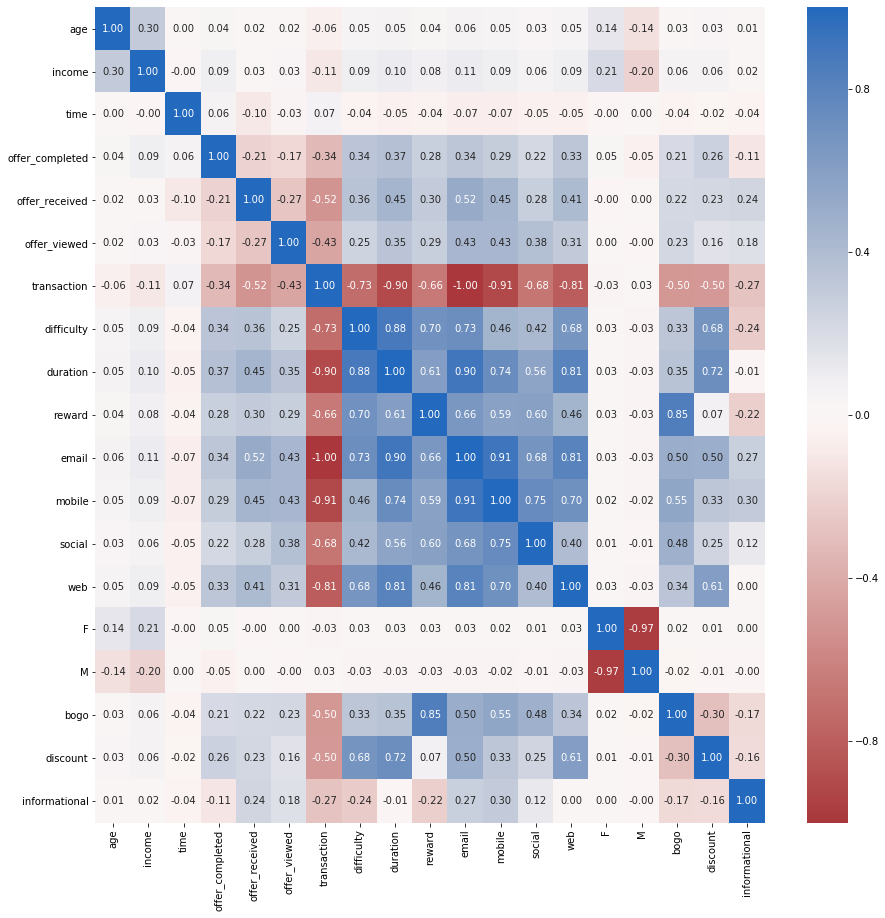

In [146]:
plt.figure(figsize=(15,15))
sns.heatmap(df_mod1.corr(), annot = True, fmt = '.2f', cmap = 'vlag_r', center = 0)